## Bahdanau注意力
9.7节中探讨了机器翻译问题：通过设计⼀个基于两个循环神经⽹络的编码器-解码器架构，⽤于序列到序列
学习。具体来说，循环神经⽹络编码器将⻓度可变的序列转换为固定形状的上下⽂变量，然后循环神经⽹络
解码器根据⽣成的词元和上下⽂变量按词元⽣成输出（⽬标）序列词元。然⽽，即使并⾮所有输⼊（源）词
元都对解码某个词元都有⽤，在每个解码步骤中仍使⽤编码相同的上下⽂变量。有什么⽅法能改变上下⽂变
量呢？

我们试着从 (Graves, 2013)中找到灵感：在为给定⽂本序列⽣成⼿写的挑战中，Graves设计了⼀种可微注意⼒
模型，将⽂本字符与更⻓的笔迹对⻬，其中对⻬⽅式仅向⼀个⽅向移动。受学习对⻬想法的启发，Bahdanau等
⼈提出了⼀个没有严格单向对⻬限制的可微注意⼒模型 (Bahdanau et al., 2014)。在预测词元时，如果不是所
有输⼊词元都相关，模型将仅对⻬（或参与）输⼊序列中与当前预测相关的部分。这是通过将上下⽂变量视
为注意⼒集中的输出来实现的。
### 模型
下⾯描述的Bahdanau注意⼒模型将遵循 9.7节中的相同符号表达。这个新的基于注意⼒的模型与 9.7节中的
模型相同，只不过 (9.7.3)中的上下⽂变量c 在任何解码时间步t ′ 都会被c t ′ 替换。假设输⼊序列中有T个词元，
解码时间步t ′ 的上下⽂变量是注意⼒集中的输出：
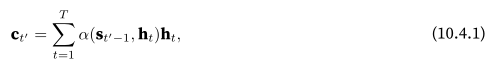
其中，时间步t ′ − 1时的解码器隐状态s t ′ −1 是查询，编码器隐状态h t 既是键，也是值，注意⼒权重α是使⽤
(10.3.2) 所定义的加性注意⼒打分函数计算的。

与 图9.7.2中的循环神经⽹络编码器-解码器架构略有不同，图10.4.1描述了Bahdanau注意⼒的架构。
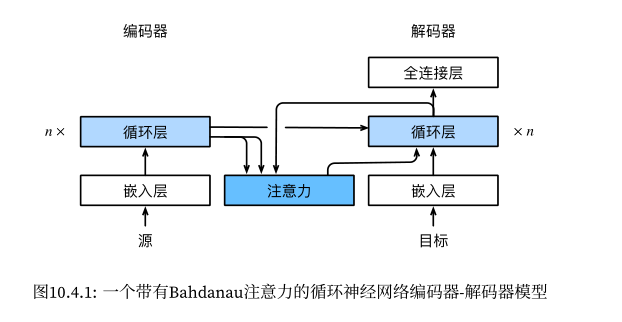

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

### 定义注意力解码器
下⾯看看如何定义Bahdanau注意⼒，实现循环神经⽹络编码器-解码器。其实，我们只需重新定义解码器即
可。为了更⽅便地显⽰学习的注意⼒权重，以下AttentionDecoder类定义了带有注意⼒机制解码器的基本接
⼝。

In [ ]:
# d2l.AttentionDecoder
class AttentionDecoder(d2l.Decoder):
    """带有注意力机制解码器的基本接口"""
    def __init__(self, **kwargs):
        super(AttentionDecoder, self).__init__(**kwargs)
        
    @property
    def attention_weights(self):
        raise NotImplementedError

接下来，让我们在接下来的Seq2SeqAttentionDecoder类中实现带有Bahdanau注意⼒的循环神经⽹络解码器。
⾸先，初始化解码器的状态，需要下⾯的输⼊：

1. 编码器在所有时间步的最终层隐状态，将作为注意⼒的键和值；
2. 上⼀时间步的编码器全层隐状态，将作为初始化解码器的隐状态；
3. 编码器有效⻓度（排除在注意⼒池中填充词元）。

在每个解码时间步骤中，解码器上⼀个时间步的最终层隐状态将⽤作查询。因此，注意⼒输出和输⼊嵌⼊都
连结为循环神经⽹络解码器的输⼊。

In [ ]:
class Seq2SeqAttentionDecoder(AttentionDecoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqAttentionDecoder, self).__init__(**kwargs)
        self.attention = d2l.AdditiveAttention(
            num_hiddens, num_hiddens, num_hiddens, dropout)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(
            embed_size + num_hiddens, num_hiddens, num_layers,
            dropout=dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)
        
    def init_state(self, enc_outputs, enc_valid_lens, *args):
        # outputs的形状为(batch_size, num_steps, num_hiddens)
        # hidden_state的形状为(num_layers, batch_size, num_hiddens)
        outputs, hidden_state = enc_outputs
        return (outputs.permute(1, 0, 2), hidden_state, enc_valid_lens)
    
    def forward(self, X, state):
        # enc_outputs的形状为(batch_size, num_steps, num_hiddens)
        # hidden_state的形状为(num_layers, batch_size, num_hiddens)
        enc_outputs, hidden_state, enc_valid_lens = state
        # 输出X的形状为(num_steps, batch_size, embed_size)
        X = self.embedding(X).permute(1, 0, 2)
        outputs, self._attention_weights = [], []
        for x in X:
            # query的形状为(batch_size, 1, num_hiddens)
            query = torch.unsqueeze(hidden_state[-1], dim=1)
            # context的形状为(batch_size, 1, num_hiddens)
            context = self.attention(
                query, enc_outputs, enc_outputs, enc_valid_lens)
            # 在特征维度上连接
            x = torch.cat((context, torch.unsqueeze(x, dim=1)), dim=-1)
            # 将x变形为(1, batch_size, embed_size+num_hiddens)
            out, hidden_state = self.rnn(x.permute(1, 0, 2), hidden_state)
            outputs.append(out)
            self._attention_weights.append(self.attention.attention_weights)
        # 全连接层变换后, outputs的形状为
        # (num_steps, batch_size, vocab_size)
        outputs = self.dense(torch.cat(outputs, dim=0))
        return outputs.permute(1, 0, 2), [enc_outputs, hidden_state,
                                          enc_valid_lens]
    
    @property
    def attention_weights(self):
        return self._attention_weights

接下来，使⽤包含7个时间步的4个序列输⼊的⼩批量测试Bahdanau注意⼒解码器。

In [ ]:
encoder = d2l.Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16,
                             num_layers=2)
encoder.eval()
decoder = Seq2SeqAttentionDecoder(vocab_size=10, embed_size=8, num_hiddens=16,
                                  num_layers=2)
decoder.eval()
X = torch.zeros((4, 7), dtype=torch.long) # (batch_size, num_steps)
state = decoder.init_state(encoder(X), None)
output, state = decoder(X, state)
output.shape, len(state), state[0].shape, len(state[1]), state[1][0].shape

### 训练
与 9.7.4节类似，我们在这⾥指定超参数，实例化⼀个带有Bahdanau注意⼒的编码器和解码器，并对这个模
型进⾏机器翻译训练。由于新增的注意⼒机制，训练要⽐没有注意⼒机制的 9.7.4节慢得多。

In [ ]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 250, d2l.try_gpu()

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)
encoder = d2l.Seq2SeqEncoder(
    len(src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqAttentionDecoder(
    len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
net = d2l.EncoderDecoder(encoder, decoder)
d2l.train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

模型训练后，我们⽤它将⼏个英语句⼦翻译成法语并计算它们的BLEU分数。

In [ ]:
engs = ['go .', "i lost .", "he\'s calm .", "i\'m home ."]
fras = ['va !', "j\'ai perdu .", 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = d2l.predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device, True)
    print(f'{eng}=>{translation}, ',
          f'bleu {d2l.bleu(translation, fra, k=2):.3f}')

In [ ]:
attention_weights = torch.cat([step[0][0][0] for step in dec_attention_weight_seq], 0).reshape((
    1, 1, -1, num_steps))

In [ ]:
# 加上一个包含序列结束词元
d2l.show_heatmaps(
    attention_weights[:, :, :, :len(engs[-1].split()) + 1].cpu(),
    xlabel='Key positions', ylabel='Query positions')

#### ⼩结
    • 在预测词元时，如果不是所有输⼊词元都是相关的，那么具有Bahdanau注意⼒的循环神经⽹络编码器-解码器会有选择地统计输⼊序列的不同部分。这是通过将上下⽂变量视为加性注意⼒池化的输出来实现的。
    • 在循环神经⽹络编码器-解码器中，Bahdanau注意⼒将上⼀时间步的解码器隐状态视为查询，在所有时间步的编码器隐状态同时视为键和值。

## 多头注意力
在实践中，当给定相同的查询、键和值的集合时，我们希望模型可以基于相同的注意⼒机制学习到不同的⾏
为，然后将不同的⾏为作为知识组合起来，捕获序列内各种范围的依赖关系（例如，短距离依赖和⻓距离依
赖关系）。因此，允许注意⼒机制组合使⽤查询、键和值的不同 ⼦空间表⽰（representation subspaces）可
能是有益的。

为此，与其只使⽤单独⼀个注意⼒汇聚，我们可以⽤独⽴学习得到的h组不同的线性投影（linearprojections）
来变换查询、键和值。然后，这h组变换后的查询、键和值将并⾏地送到注意⼒汇聚中。最后，将这h个注意
⼒汇聚的输出拼接在⼀起，并且通过另⼀个可以学习的线性投影进⾏变换，以产⽣最终输出。这种设计被称
为多头注意⼒（multihead attention）(Vaswani et al., 2017)。对于h个注意⼒汇聚输出，每⼀个注意⼒汇聚都
被称作⼀个头（head）。图10.5.1 展⽰了使⽤全连接层来实现可学习的线性变换的多头注意⼒。
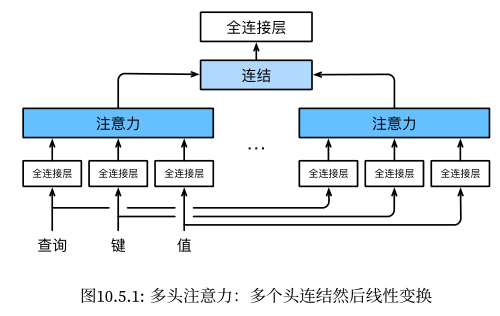
### 模型
在实现多头注意⼒之前，让我们⽤数学语⾔将这个模型形式化地描述出来。给定查询q ∈ R d q 、键k ∈ R d k 和
值v ∈ R d v ，每个注意⼒头h i （i = 1,...,h）的计算⽅法为：
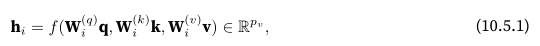
其中，可学习的参数包括W (q)
i
∈ R p q ×d q 、W (k)
i
∈ R p k ×d k 和W (v)
i
∈ R p v ×d v ，以及代表注意⼒汇聚的函数f。f可
以是 10.3节中的加性注意⼒和缩放点积注意⼒。多头注意⼒的输出需要经过另⼀个线性转换，它对应着h个
头连结后的结果，因此其可学习参数是 W o ∈ R p o ×hp v ：
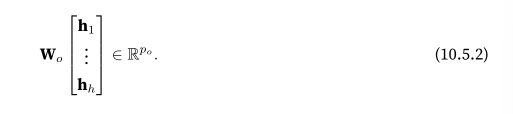
基于这种设计，每个头都可能会关注输⼊的不同部分，可以表⽰⽐简单加权平均值更复杂的函数。

In [1]:
import torch
import math
from torch import nn
from d2l import torch as d2l

### 实现
在实现过程中通常选择缩放点积注意⼒作为每⼀个注意⼒头。为了避免计算代价和参数代价的⼤幅增⻓，我
们设定p q = p k = p v = p o /h。值得注意的是，如果将查询、键和值的线性变换的输出数量设置为 p q h = p k h =
p v h = p o ，则可以并⾏计算h个头。在下⾯的实现中，p o 是通过参数num_hiddens指定的。

In [ ]:
# d2l.MultiHeadAttention
class MultiHeadAttention(nn.Module):
    """多头注意力"""
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 num_heads, dropout, bias=False, **kwargs):
        super(MultiHeadAttention, self).__init__(**kwargs)
        self.num_heads = num_hiddens
        self.attention = d2l.DotProductAttention(dropout)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=bias)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=bias)
        self.W_v = nn.Linear(value_size, num_hiddens, bias=bias)
        self.W_o = nn.Linear(num_hiddens, num_hiddens, bias)
        
    def forward(self, queries, keys, values, valid_lens):
        # queries, keys, values的形状
        # (batch_size, 查询或者"键-值"对的个数，num_hiddens)
        # valid_lens的形状
        # (batch_size, )或者(batch_size, 查询的个数)
        # 经过变换后，输出的queries,keys,values的形状
        # (batch_size*num_heads, 查询或者"键-值"对的个数，num_hiddens/num_heads)
        queries = transpose_qkv(self.W_q(queries), self.num_heads)
        keys = transpose_qkv(self.W_k(keys), self.num_heads)
        values = transpose_qkv(self.W_v(values), self.num_heads)
        if valid_lens is not None:
            # 在轴0，将第一项(标量或者矢量)复制num_heads次
            # 然后如此复制第二项，然后诸如此类
            valid_lens = torch.repeat_interleave(
                valid_lens, repeats=self.num_heads, dim=0)
        
        # output的形状: (batch_size*numheads, 查询的个数，
        # num_hiddens/num_heads)
        output = self.attention(queries, keys, values, valid_lens)
        
        # output_concat的形状:(batch_size, 查询个数，num_hiddens)
        output_concat = transpose_output(output, self.num_heads)
        return self.W_o(output_concat)

为了能够使多个头并⾏计算，上⾯的MultiHeadAttention类将使⽤下⾯定义的两个转置函数。具体来说，trans
pose_output函数反转了transpose_qkv函数的操作。

In [ ]:
# d2l.transpose_qkv
def transpose_qkv(X, num_heads):
    """为了多注意力头的并行计算而变换形状"""
    # 输入X的形状:(batch_size, 查询或者"键-值"对的个数，num_hiddens)
    # 输出X的形状:(batch_size, 查询或者"键-值"对的个数，num_heads，num_hiddens/num_heads)
    X = X.reshape(X.shape[0], X.shape[1], num_heads, -1)
    
    # 输出X的形状:(batch_size, num_heads, 查询或者"键-值"对的个数，num_hiddens/num_heads)
    X = X.permute(0, 2, 1, 3)
    
    # 最终输出的形状:(batch_size*num_heads, 查询或者"键-值"对的个数，num_hiddens/num_heads)
    return X.reshape(-1, X.shape[2], X.shape[3])

# d2l.transpose_output
def transpose_output(X, num_heads):
    """逆转transpose_qkv函数的操作"""
    X = X.reshape(-1, num_heads, X.shape[1], X.shape[2])
    X = X.permute(0, 2, 1, 3)
    return X.reshape(X.shape[0], X.shape[1], -1)

下⾯使⽤键和值相同的⼩例⼦来测试我们编写的MultiHeadAttention类。多头注意⼒输出的形状是
下⾯使⽤键和值相同的⼩例⼦来测试我们编写的MultiHeadAttention类。多头注意⼒输出的形状是

In [ ]:
num_hiddens, num_heads = 100, 5
attention = MultiHeadAttention(num_hiddens, num_hiddens, num_hiddens,
                               num_hiddens, num_heads, 0.5)
attention.eval()

In [ ]:
batch_size, num_queries = 2, 4
num_kvpairs, valid_lens = 6, torch.tensor([3, 2])
X = torch.ones((batch_size, num_queries, num_hiddens))
Y = torch.ones((batch_size, num_kvpairs, num_hiddens))
attention(X, Y, Y, valid_lens).shape

#### ⼩结
    • 多头注意⼒融合了来⾃于多个注意⼒汇聚的不同知识，这些知识的不同来源于相同的查询、键和值的不同的⼦空间表⽰。
    • 基于适当的张量操作，可以实现多头注意⼒的并⾏计算。

## 自注意力和位置编码
在深度学习中，经常使⽤卷积神经⽹络（CNN）或循环神经⽹络（RNN）对序列进⾏编码。想象⼀下，有了注
意⼒机制之后，我们将词元序列输⼊注意⼒池化中，以便同⼀组词元同时充当查询、键和值。具体来说，每个
查询都会关注所有的键－值对并⽣成⼀个注意⼒输出。由于查询、键和值来⾃同⼀组输⼊，因此被称为 ⾃注
意⼒（self-attention）(Lin et al., 2017, Vaswani et al., 2017)，也被称为内部注意⼒（intra-attention）(Cheng
et al., 2016, Parikh et al., 2016, Paulus et al., 2017)。本节将使⽤⾃注意⼒进⾏序列编码，以及如何使⽤序列
的顺序作为补充信息。

In [2]:
import math
import torch
from torch import nn
from d2l import torch as d2l

### 自注意力
给定⼀个由词元组成的输⼊序列x 1 ,...,x n ，其中任意x i ∈ R d （1 ≤ i ≤ n）。该序列的⾃注意⼒输出为⼀个⻓
度相同的序列 y 1 ,...,y n ，其中：
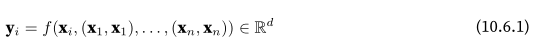
根据 (10.2.4)中定义的注意⼒汇聚函数f。下⾯的代码⽚段是基于多头注意⼒对⼀个张量完成⾃注意⼒的计
算，张量的形状为（批量⼤⼩，时间步的数⽬或词元序列的⻓度，d）。输出与输⼊的张量形状相同。

In [ ]:
num_hiddens, num_heads = 100, 5
attention = d2l.MultiHeadAttention(num_hiddens, num_hiddens, num_hiddens,
                                   num_hiddens, num_heads, 0.5)
attention.eval()

In [ ]:
batch_size, num_queries, valid_lens = 2, 4, torch.tensor([3, 2])
X = torch.ones((batch_size, num_queries, num_hiddens))
attention(X, X, X, valid_lens).shape

### 比较CNN、RNN和自注意力
接下来⽐较下⾯⼏个架构，⽬标都是将由n个词元组成的序列映射到另⼀个⻓度相等的序列，其中的每个输
⼊词元或输出词元都由d维向量表⽰。具体来说，将⽐较的是卷积神经⽹络、循环神经⽹络和⾃注意⼒这⼏
个架构的计算复杂性、顺序操作和最⼤路径⻓度。请注意，顺序操作会妨碍并⾏计算，⽽任意的序列位置组
合之间的路径越短，则能更轻松地学习序列中的远距离依赖关系 (Hochreiter et al., 2001)。
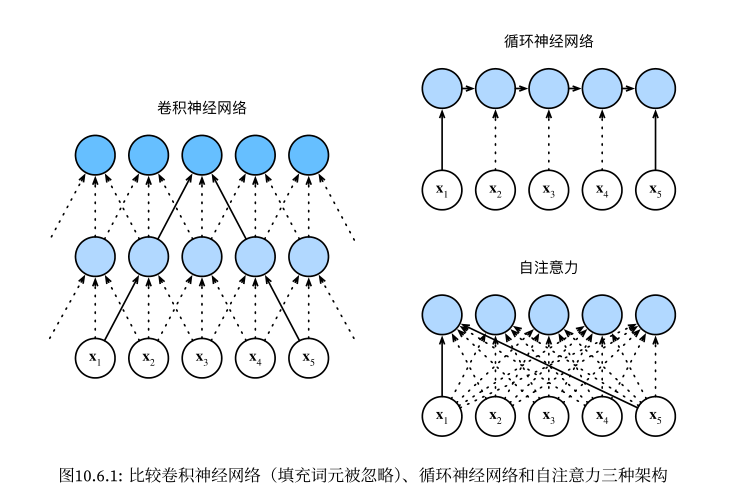
考虑⼀个卷积核⼤⼩为k的卷积层。在后⾯的章节将提供关于使⽤卷积神经⽹络处理序列的更多详细信息。⽬
前只需要知道的是，由于序列⻓度是n，输⼊和输出的通道数量都是d，所以卷积层的计算复杂度为O(knd 2 )。
如图10.6.1所⽰，卷积神经⽹络是分层的，因此为有O(1)个顺序操作，最⼤路径⻓度为O(n/k)。例如，x 1 和x 5 处
于 图10.6.1中卷积核⼤⼩为3的双层卷积神经⽹络的感受野内。

当更新循环神经⽹络的隐状态时，d×d权重矩阵和d维隐状态的乘法计算复杂度为O(d 2 )。由于序列⻓度为n，
因此循环神经⽹络层的计算复杂度为O(nd 2 )。根据 图10.6.1，有O(n)个顺序操作⽆法并⾏化，最⼤路径⻓度
也是O(n)。

在⾃注意⼒中，查询、键和值都是n × d矩阵。考虑 (10.3.5)中缩放的”点－积“注意⼒，其中n × d矩阵乘
以d×n矩阵。之后输出的n×n矩阵乘以n×d矩阵。因此，⾃注意⼒具有O(n 2 d)计算复杂性。正如在图10.6.1中
所讲，每个词元都通过⾃注意⼒直接连接到任何其他词元。因此，有O(1)个顺序操作可以并⾏计算，最⼤路
径⻓度也是O(1)。

总⽽⾔之，卷积神经⽹络和⾃注意⼒都拥有并⾏计算的优势，⽽且⾃注意⼒的最⼤路径⻓度最短。但是因为
其计算复杂度是关于序列⻓度的⼆次⽅，所以在很⻓的序列中计算会⾮常慢。

### 位置编码
在处理词元序列时，循环神经⽹络是逐个的重复地处理词元的，⽽⾃注意⼒则因为并⾏计算⽽放弃了顺序操
作。为了使⽤序列的顺序信息，通过在输⼊表⽰中添加 位置编码（positional encoding）来注⼊绝对的或相
对的位置信息。位置编码可以通过学习得到也可以直接固定得到。接下来描述的是基于正弦函数和余弦函数
的固定位置编码 (Vaswani et al., 2017)。

假设输⼊表⽰X ∈ R n×d 包含⼀个序列中n个词元的d维嵌⼊表⽰。位置编码使⽤相同形状的位置嵌⼊矩阵
P ∈ R n×d 输出X + P，矩阵第i⾏、第2j列和2j + 1列上的元素为：
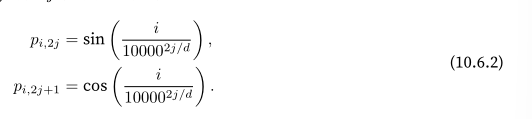
乍 ⼀ 看， 这 种 基 于 三 ⻆ 函 数 的 设 计 看 起 来 很 奇 怪。 在 解 释 这 个 设 计 之 前， 让 我 们 先 在 下 ⾯
的PositionalEncoding类中实现它。

In [ ]:
# d2l.PositionalEncoding
class PositionalEncoding(nn.Module):
    """位置编码"""
    def __init__(self, num_hiddens, dropout, max_len = 1000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(dropout)
        # 创建一个足够长的p
        self.P = torch.zeros((1, max_len, num_hiddens))
        X = torch.arange(max_len, dtype=torch.float32).reshape(
            -1, 1) / torch.pow(10000, torch.arange(
            0, num_hiddens, 2, dtype=torch.float32) / num_hiddens)
        self.P[:, :, 0::2] = torch.sin(X)
        self.P[:, :, 1::2] = torch.cos(X)
        
    def forward(self, X):
        X = X + self.P[:, :X.shape[1], :].to(X.device)
        return self.dropout(X)

在位置嵌⼊矩阵P中，⾏代表词元在序列中的位置，列代表位置编码的不同维度。从下⾯的例⼦中可以看到位
置嵌⼊矩阵的第6列和第7列的频率⾼于第8列和第9列。第6列和第7列之间的偏移量（第8列和第9列相同）是由于正弦函数和余弦函数的交替。

In [ ]:
encoding_dim, num_steps = 32, 60
pos_encoding = PositionalEncoding(encoding_dim, 0)
pos_encoding.eval()
X = pos_encoding(torch.zeros((1, num_steps, encoding_dim)))
P = pos_encoding.P[:, :X.shape[1], :]
d2l.plot(torch.arange(num_steps), P[0, :, 6:10].T, xlabel='Row (position)',
         figsize=(6, 2.5), legend=['Col %d' % d for d in torch.arange(6, 10)])

#### 绝对位置信息
为了明⽩沿着编码维度单调降低的频率与绝对位置信息的关系，让我们打印出0,1,...,7的⼆进制表⽰形式。
正如所看到的，每个数字、每两个数字和每四个数字上的⽐特值在第⼀个最低位、第⼆个最低位和第三个最
低位上分别交替。

In [3]:
for i in range(8):
    print(f'{i}的二进制是: {i:>03b}')

0的二进制是: 000
1的二进制是: 001
2的二进制是: 010
3的二进制是: 011
4的二进制是: 100
5的二进制是: 101
6的二进制是: 110
7的二进制是: 111


在⼆进制表⽰中，较⾼⽐特位的交替频率低于较低⽐特位，与下⾯的热图所⽰相似，只是位置编码通过使⽤三⻆函数在编码维度上降低频率。由于输出是浮点数，因此此类连续表⽰⽐⼆进制表⽰法更节省空间。

In [ ]:
P = P[0, :, :].unsqueeze(0).unsqueeze(0)
d2l.show_heatmaps(P, xlabel='Column (encoding dimension)',
                  ylabel='Row (position)', figsize=(3.5, 4), cmap='Blues')

#### 相对位置信息
除了捕获绝对位置信息之外，上述的位置编码还允许模型学习得到输⼊序列中相对位置信息。这是因为对于
任何确定的位置偏移δ，位置i + δ处的位置编码可以线性投影位置i处的位置编码来表⽰。

这种投影的数学解释是，令ω j = 1/10000 2j/d ，对于任何确定的位置偏移δ，(10.6.2)中的任何⼀对
(p i,2j ,p i,2j+1 )都可以线性投影到 (p i+δ,2j ,p i+δ,2j+1 )：
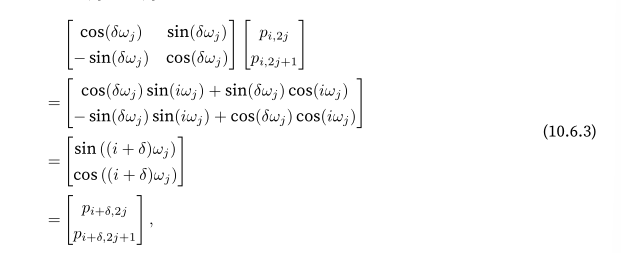
2 × 2投影矩阵不依赖于任何位置的索引i。
#### ⼩结
    • 在⾃注意⼒中，查询、键和值都来⾃同⼀组输⼊。
    • 卷积神经⽹络和⾃注意⼒都拥有并⾏计算的优势，⽽且⾃注意⼒的最⼤路径⻓度最短。但是因为其计算复杂度是关于序列⻓度的⼆次⽅，所以在很⻓的序列中计算会⾮常慢。
    • 为了使⽤序列的顺序信息，可以通过在输⼊表⽰中添加位置编码，来注⼊绝对的或相对的位置信息。